# Caso d'Uso
Scenario reale: Mario Rossi, community manager di TechTalk, si occupa quotidianamente della moderazione manuale dei contenuti generati dagli utenti. Con l’aumento del traffico sulla piattaforma, Mario non riesce più a gestire manualmente la quantità di commenti dannosi, e deve trovare un modo per filtrare automaticamente i commenti offensivi, minacciosi o osceni senza rallentare l'esperienza utente.

Requisiti Tecnici del Modello
Task: Classificazione multi-label dei commenti in 6 categorie:

* Toxic (Tossico)
* Severely Toxic (Super Tossico)
* Obscene (Osceno)
* Threat (Minaccia)
* Insult (Insulto)
* Identity Hate (Odio basato sull’identità)

Dataset: Un dataset di 160.000 commenti sarà fornito, con ogni commento etichettato in una o più delle categorie sopra indicate. I commenti possono avere zero o più label attive.

Architettura: Il modello deve includere layer ricorrenti (ad esempio, LSTM o GRU) per gestire la natura sequenziale dei commenti testuali.

Output: A livello di inferenza, per ogni commento, il modello dovrà produrre un vettore di 6 elementi (uno per ogni label), con valori binari (0 o 1), dove 1 indica la presenza della label corrispondente e 0 la sua assenza.

Fasi del Progetto
1. Preprocessing dei Dati:

I commenti testuali devono essere convertiti in sequenze numeriche (tokenizzazione).
I dati devono essere normalizzati e bilanciati per garantire che tutte le categorie di tossicità siano rappresentate equamente.

2. Sviluppo del Modello:

Il modello di deep learning sarà basato su un'architettura ricorrente, in grado di catturare le dipendenze a lungo termine tra le parole nei commenti.
Verranno implementati strati ricorrenti (LSTM o GRU) per il task di classificazione multi-label.

3. Training del Modello:

Il dataset sarà suddiviso in training, validation e test set.
Utilizzo di tecniche di ottimizzazione avanzata per migliorare la convergenza del modello.

4. Inferenza e Predizione:

Durante il tempo di inferenza, per ogni commento, il modello restituirà un vettore di 6 elementi con 0 o 1, a seconda della presenza di tossicità in una o più delle categorie previste.

5. Validazione:

Il modello sarà valutato utilizzando metriche come **accuracy, F1-score** per ciascuna categoria, e **precisione globale** nella previsione delle label multiple.

# Import Libraries

In [ ]:
# no warning
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
#dataframe preprocessing
import pandas as pd
import numpy as np

#preprocessing text
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

#Divide df and RNN
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional, Flatten, TextVectorization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix ,hamming_loss
from keras.backend import clear_session

#data visasualization
import matplotlib.pyplot as plt
import seaborn as sns



# Load Dataset

In [ ]:
#load dataset
BASE_URL = 'https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/'
df = pd.read_csv(BASE_URL+'Filter_Toxic_Comments_dataset.csv')
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,0


In [ ]:
df_info = {
    'columns': df.columns.tolist(),
    'missing_values': df.isnull().sum(),
    'shape': df.shape,
    'categories_distribution': df.iloc[:, 1:].sum(),
    'duplicates values': df.duplicated().sum()
}

for key, value in df_info.items():
    print(f'{key.capitalize()}:')
    print(value)
    print('\n' + '*'*50 + '\n')

Columns:
['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'sum_injurious']

**************************************************

Missing_values:
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64

**************************************************

Shape:
(159571, 8)

**************************************************

Categories_distribution:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
sum_injurious    35098
dtype: int64

**************************************************

Duplicates values:
0

**************************************************



* Number of rows: 159,571
* Number of columns: 8

Distribution of Toxicity Categories:
* Toxic: 15,294 comments.
* Severe Toxic: 1,595 comments.
* Obscene: 8,449 comments.
* Threat: 478 comments.
* Insult: 7,877 comments.
* Identity Hate: 1,405 comments.

There are no null or duplicate values in any column.

# Exploratory Data Analysis

In [ ]:
labels = df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

# Impostare lo stile dei grafici
sns.set_style('whitegrid')

categories_distribution = labels.sum()
categories_distribution

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


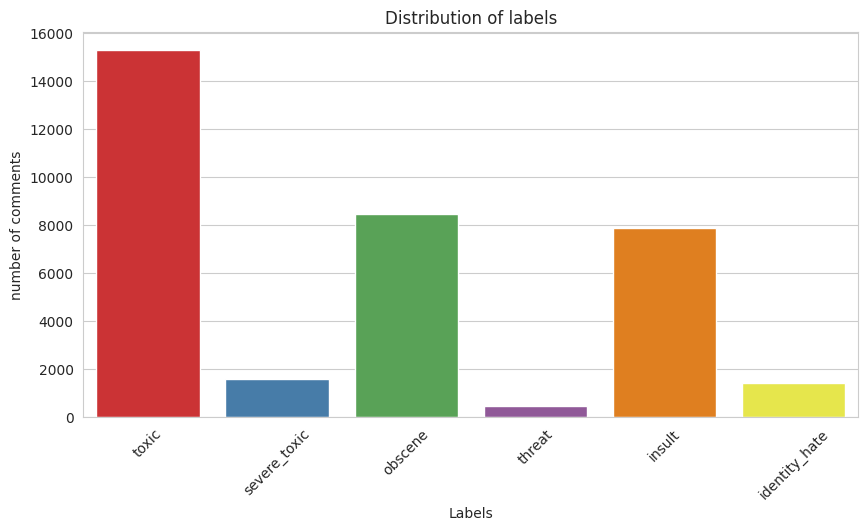

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=categories_distribution.index, y=categories_distribution.values, palette='Set1')
plt.xlabel('Labels')
plt.ylabel('number of comments')
plt.title('Distribution of labels')
plt.xticks(rotation=45)
plt.show()

The graph involves the distribution of lables.

* Toxic comments are 15.294
* Severe Toxic comments are 1595
* Obscene comments are 8449
* Threat comments are 478
* Insult comments are 7877
* Identity hate comments are 1406

The three categories (Toxic, Obscene and Insult) appear to be the most used categories in the dataset.
This is followed by Severe toxic,Identity Hate and finally Threat.

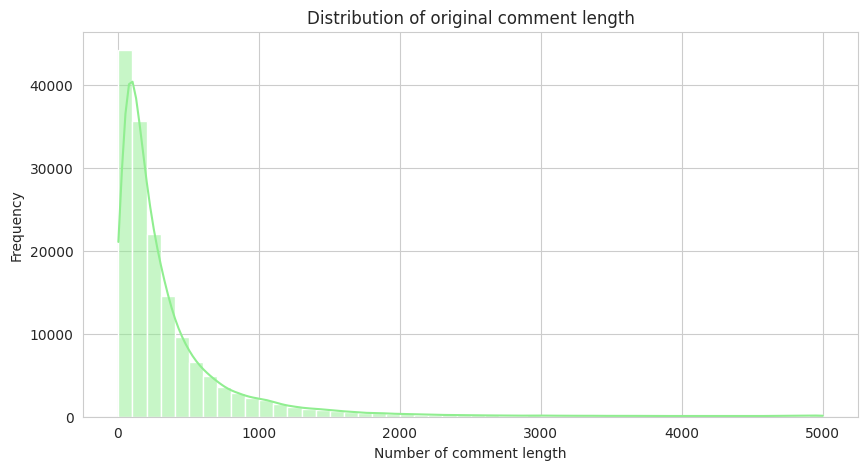

In [ ]:
df['comment_length'] = df['comment_text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df['comment_length'], bins=50, kde=True, color='lightgreen')
plt.xlabel('Number of comment length')
plt.ylabel('Frequency')
plt.title('Distribution of original comment length')
plt.show()

In [ ]:
df['comment_length'].describe()

,comment_length
count,159571.000000
mean,394.073221
std,590.720282
min,6.000000
25%,96.000000
50%,205.000000
75%,435.000000
max,5000.000000


The graph represents the distribution of comment length (including special characters, punctuation, etc.) before the preprocessing and cleaning phase.

It can be seen that the smallest comment has 6 characters and the largest 5000.

The standard deviation is higher than the mean, which could indicate the presence of outliers (comments of abnormal length) or a very scattered distribution.

If the difference between *Q1* and *minimum* or *Q3* and *maximum* is much larger than in the other intervals, outliers may be present.

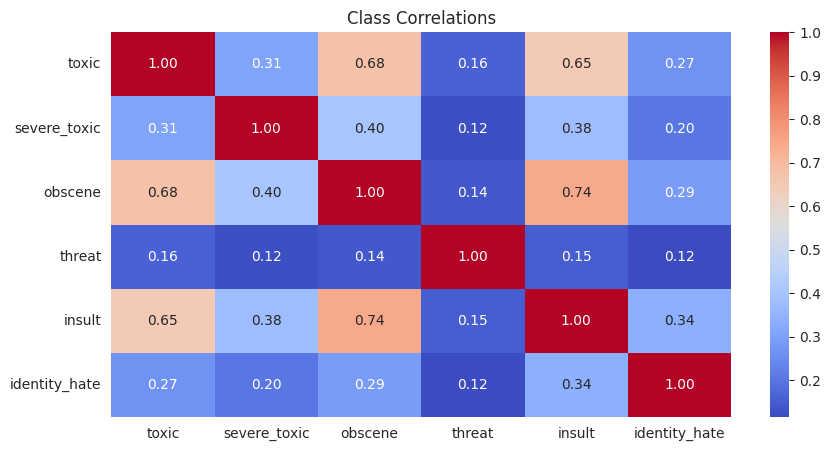

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(labels.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Class Correlations')
plt.show()

Thanks fo matrix correlation, we can conferm that *toxic,obscene and insult* comments are strongly correlated.

* 74% correlation between *insult* and *obscene* comments (Strong correlation)
* 68% correlation between *toxic* and *obscene* comments (Strong correlation)
* 65% correlation between *toxic* and *insult* comments (Strong correlation)
* 12% - 34% correlation between *identity hate* and *threat* comments (Low correlation)

The model might struggle to reveal *identity hate* and *threat* comments because does not have a large number of examples and the correlation is low.

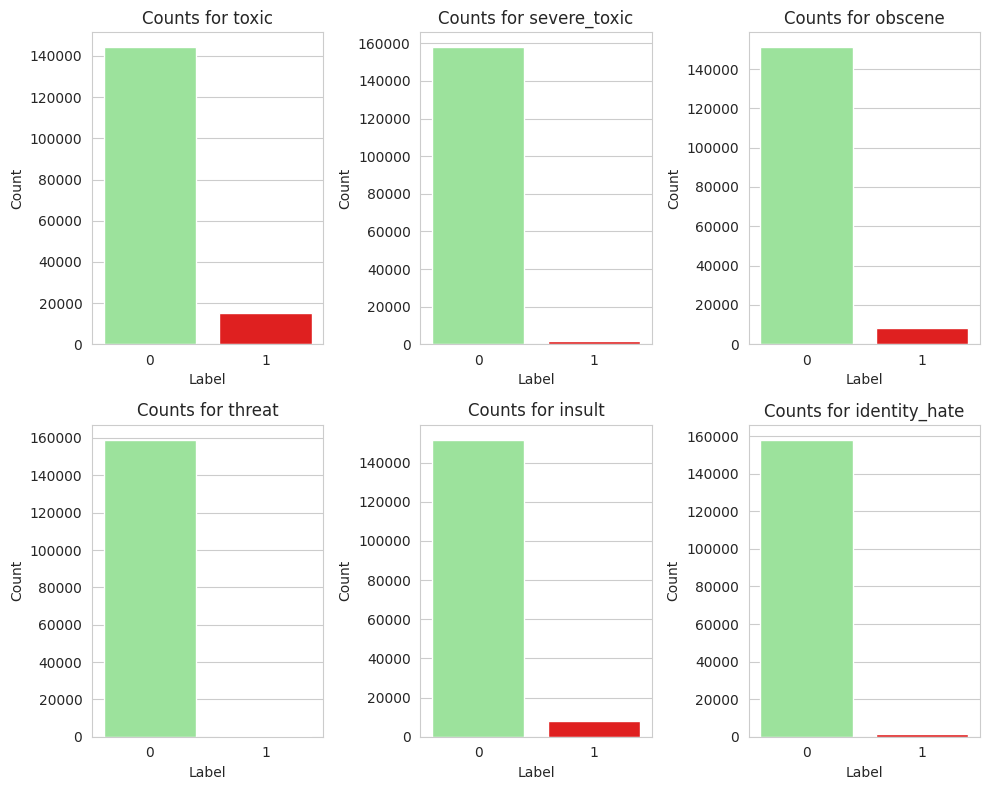

In [ ]:
only_labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

plt.figure(figsize=(10, 8))

for i, only_label in enumerate(only_labels, 1):
    counts = df[only_label].value_counts()


    plt.subplot(2, 3, i)
    sns.barplot(x=counts.index, y=counts.values, palette=['lightgreen','red'])


    plt.title(f'Counts for {only_label}')
    plt.xlabel('Label')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


Every labels is unbalanced.
Minority classes need to be balanced if the model is to train effectively.  

In [ ]:
# Download NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

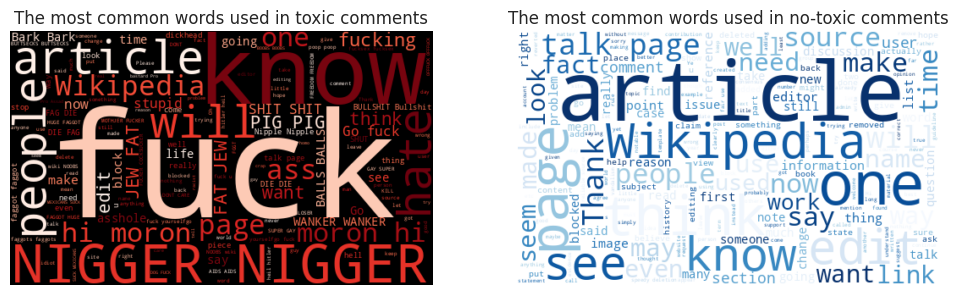

In [ ]:
# join toxic and not toxic comments
toxic_comments = ' '.join(df[df['toxic'] == 1]['comment_text'])
non_toxic_comments = ' '.join(df[df['toxic'] == 0]["comment_text"])

# Create wordcloud
plt.figure(figsize=(12, 6))

# Wordcloud for toxic comments
plt.subplot(1, 2, 1)
wordcloud_toxic = WordCloud(width=500, height=300, background_color='black', colormap='Reds').generate(toxic_comments)
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('The most common words used in toxic comments')

# Wordcloud for no toxic comments
plt.subplot(1, 2, 2)
wordcloud_non_toxic = WordCloud(width=500, height=300, background_color='white', colormap='Blues').generate(non_toxic_comments)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')
plt.axis('off')
plt.title('The most common words used in no-toxic comments')
plt.show()

Wordcloud represents the most frequently used words in toxic and non-toxic comments.

# Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords

def clean_text(text):
    # Remove punctuation and number
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # all text in lowercase
    words = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization (base form)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Reconstructs clean text
    return " ".join(words)

#prova della funzione
example_text = df['comment_text'][0]
example_text1 = df['comment_text'][1]
example_text2 = df['comment_text'][2]

cleaned_text = clean_text(example_text)
cleaned_text1 = clean_text(example_text1)
cleaned_text2 = clean_text(example_text2)
print(cleaned_text,'\n')
print(cleaned_text1,'\n')
print(cleaned_text2)

explanation edits made username hardcore metallica fan reverted werent vandalism closure gas voted new york doll fac please dont remove template talk page since im retired 

daww match background colour im seemingly stuck thanks talk january utc 

hey man im really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info


In [ ]:
df['comment_text'] = df['comment_text'].apply(clean_text)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,comment_length
0,explanation edits made username hardcore metal...,0,0,0,0,0,0,0,264
1,daww match background colour im seemingly stuc...,0,0,0,0,0,0,0,112
2,hey man im really trying edit war guy constant...,0,0,0,0,0,0,0,233
3,cant make real suggestion improvement wondered...,0,0,0,0,0,0,0,622
4,sir hero chance remember page thats,0,0,0,0,0,0,0,67


In [ ]:
df['comment_length'] = df['comment_text'].apply(len)
df['comment_length'].describe()

,comment_length
count,159571.000000
mean,247.064172
std,384.219912
min,0.000000
25%,58.000000
50%,127.000000
75%,270.000000
max,5000.000000


In [ ]:
max_length = int(df['comment_length'].quantile(0.75))
print(f'Max length: {max_length} characters')

Max length: 270 characters


With pre-processing, we removed punctuation and numbers, rewrote all sentences in lower case and applied lemmatisation.

We've found the max_length = 270 (75° percentile).

This allows us to avoid outliers, have greater computational efficiency and preserve 75% of the data.

# Define features and labels


In [ ]:
X = df.comment_text
y = labels

X.shape, y.shape

((159571,), (159571, 6))

In [ ]:
#dataset split

X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=.3, random_state=42)

X_val,X_test,y_val,y_test = train_test_split(X_temp,y_temp,test_size=.5,random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (111699,)
X_val shape: (23936,)
X_test shape: (23936,)


In [ ]:
# Count all the percentages for all occurence in the labels
train_labels = y_train.columns
val_labels = y_val.columns
test_labels = y_test.columns

# create a dict with all the percentages
train_perc = {}
val_perc = {}
test_perc = {}
for label in train_labels:
    train_perc[label] = y_train[label].sum() / len(y_train) * 100
    val_perc[label] = y_val[label].sum() / len(y_val) * 100
    test_perc[label] = y_test[label].sum() / len(y_test) * 100

# print the results
print('LABELS PRESENCE IN TRAIN SET (in %):')
for label, perc in train_perc.items():
    print(f"{label}: {perc:.2f}%")

print('\nLABELS PRESENCE IN VALIDATION SET (in %):')
for label, perc in val_perc.items():
    print(f"{label}: {perc:.2f}%")

print('\nLABELS PRESENCE IN TEST SET (in %):')
for label, perc in test_perc.items():
    print(f"{label}: {perc:.2f}%")

LABELS PRESENCE IN TRAIN SET (in %):
toxic: 9.59%
severe_toxic: 0.99%
obscene: 5.28%
threat: 0.31%
insult: 4.91%
identity_hate: 0.87%

LABELS PRESENCE IN VALIDATION SET (in %):
toxic: 9.45%
severe_toxic: 1.00%
obscene: 5.28%
threat: 0.29%
insult: 4.89%
identity_hate: 0.86%

LABELS PRESENCE IN TEST SET (in %):
toxic: 9.69%
severe_toxic: 1.03%
obscene: 5.40%
threat: 0.28%
insult: 5.09%
identity_hate: 0.94%


In [ ]:
VOCAB_SIZE = 10000
max_length = 270 #75° percentile

vectorizer = TextVectorization(max_tokens = VOCAB_SIZE,
                               standardize = 'lower_and_strip_punctuation',
                               output_sequence_length= max_length,
                               pad_to_max_tokens = True,
                               name = 'vectorizer',
                               split = 'whitespace')

vectorizer.adapt(X_train)

In [ ]:
X_train_sequences = vectorizer((X_train))
X_val_sequences = vectorizer((X_val))
X_test_sequences = vectorizer((X_test))

print(X_train_sequences.shape)
print('\n',X_train_sequences[:5])

(111699, 270)

 tf.Tensor(
[[ 530  315   93 ...    0    0    0]
 [ 934  130  349 ...    0    0    0]
 [   1    2    1 ...    0    0    0]
 [1765    1    1 ...    0    0    0]
 [  91   97   91 ...    0    0    0]], shape=(5, 270), dtype=int64)


In [ ]:
# # transfor to tensor y
y_train_tensor = tf.convert_to_tensor(y_train.to_numpy().astype(np.float32))
y_val_tensor = tf.convert_to_tensor(y_val.to_numpy().astype(np.float32))
y_test_tensor = tf.convert_to_tensor(y_test.to_numpy().astype(np.float32))

*Train, validation and test* sequences thanks to textvectorizer are converted into numerical sequences with tensor format, useful for working with keras.

We also convert the train, validation and test labels into tensors to speed up training.

In [ ]:
training = tf.data.Dataset.from_tensor_slices((X_train_sequences, y_train_tensor)).batch(32).prefetch(tf.data.AUTOTUNE)

validation = tf.data.Dataset.from_tensor_slices((X_val_sequences, y_val_tensor)).batch(32).prefetch(tf.data.AUTOTUNE)

testing = tf.data.Dataset.from_tensor_slices((X_test_sequences, y_test_tensor)).batch(32).prefetch(tf.data.AUTOTUNE)

print(type(training))
print(type(validation))
print(type(testing))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


Using tf.data.AUTOTUNE for prefetching allows TensorFlow to automatically decide the optimal number of batches to prefetch, based on available resources and the current workload.

The .batch(32) method divides the data into batches of size 32 (or any other specified size)

Overfitting signal: if the validation loss stops improving while the training loss continues to fall, the model is learning the training set too well but does not generalise the validation data.

# Build First Bidirectional LSTM Model

In [ ]:
#build RNN layers
clear_session()
input = Input(shape=(max_length,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=64)(input)
x = Bidirectional(LSTM(units=128, return_sequences=True))(embedding_layer)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
x = Flatten()(x)
output = Dense(6, activation='sigmoid')(x)

# create model
model = Model(inputs=input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 270)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 270, 64)             │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 270, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,002,822 (3.83 MB)

 Trainable params: 1,002,822 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Definiamo le callback per evitare overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')

# fit
history = model.fit(
    training,
    epochs=5,
    batch_size=64,
    validation_data=(validation),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
3490/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9716 - loss: 0.0982

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 162s 44ms/step - accuracy: 0.9716 - loss: 0.0982 - val_accuracy: 0.9939 - val_loss: 0.0514
Epoch 2/5
3490/3491 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9941 - loss: 0.0504

3491/3491 ━━━━━━━━━━━━━━━━━━━━ 155s 44ms/step - accuracy: 0.9941 - loss: 0.0504 - val_accuracy: 0.9939 - val_loss: 0.0512
Epoch 3/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 154s 44ms/step - accuracy: 0.9939 - loss: 0.0463 - val_accuracy: 0.9939 - val_loss: 0.0524
Epoch 4/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 155s 44ms/step - accuracy: 0.9938 - loss: 0.0421 - val_accuracy: 0.9939 - val_loss: 0.0550


In [ ]:
y_pred = model.predict(testing)
y_pred = (y_pred > 0.5).astype(int)

#report
print(classification_report(y_test, y_pred, target_names=['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']))

748/748 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
               precision    recall  f1-score   support

        Toxic       0.80      0.79      0.79      2320
 Severe Toxic       0.60      0.22      0.32       246
      Obscene       0.88      0.72      0.79      1293
       Threat       0.00      0.00      0.00        67
       Insult       0.73      0.65      0.69      1219
Identity Hate       0.00      0.00      0.00       225

    micro avg       0.80      0.67      0.73      5370
    macro avg       0.50      0.40      0.43      5370
 weighted avg       0.75      0.67      0.70      5370
  samples avg       0.07      0.06      0.06      5370



In [ ]:
test_loss, test_accuracy = model.evaluate(testing)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9935 - loss: 0.0498
Test Loss: 0.05122106894850731, Test Accuracy: 0.9941510558128357


In [ ]:
hamming = hamming_loss(y_test, y_pred)
print(f"Hamming Loss: {hamming:.4f}")

Hamming Loss: 0.0186


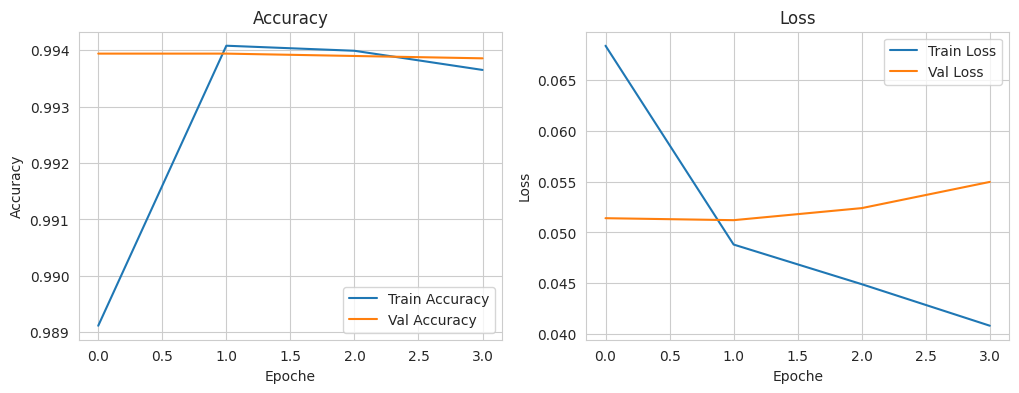

In [ ]:
# grafici loss e accuravy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()

The training accuracy grows rapidly and almost reaches 99.4%.
The validation accuracy is stable, but falls slightly after the second epoch.

**Possible overfitting**: the model learns the training data very well, but does not improve on validation

Training loss decreases steadily, which is good.
Validation Loss increasing slightly: This is a possible sign of overfitting, i.e. the model is becoming too specific on the training data and is losing its ability to generalise on the validation data.

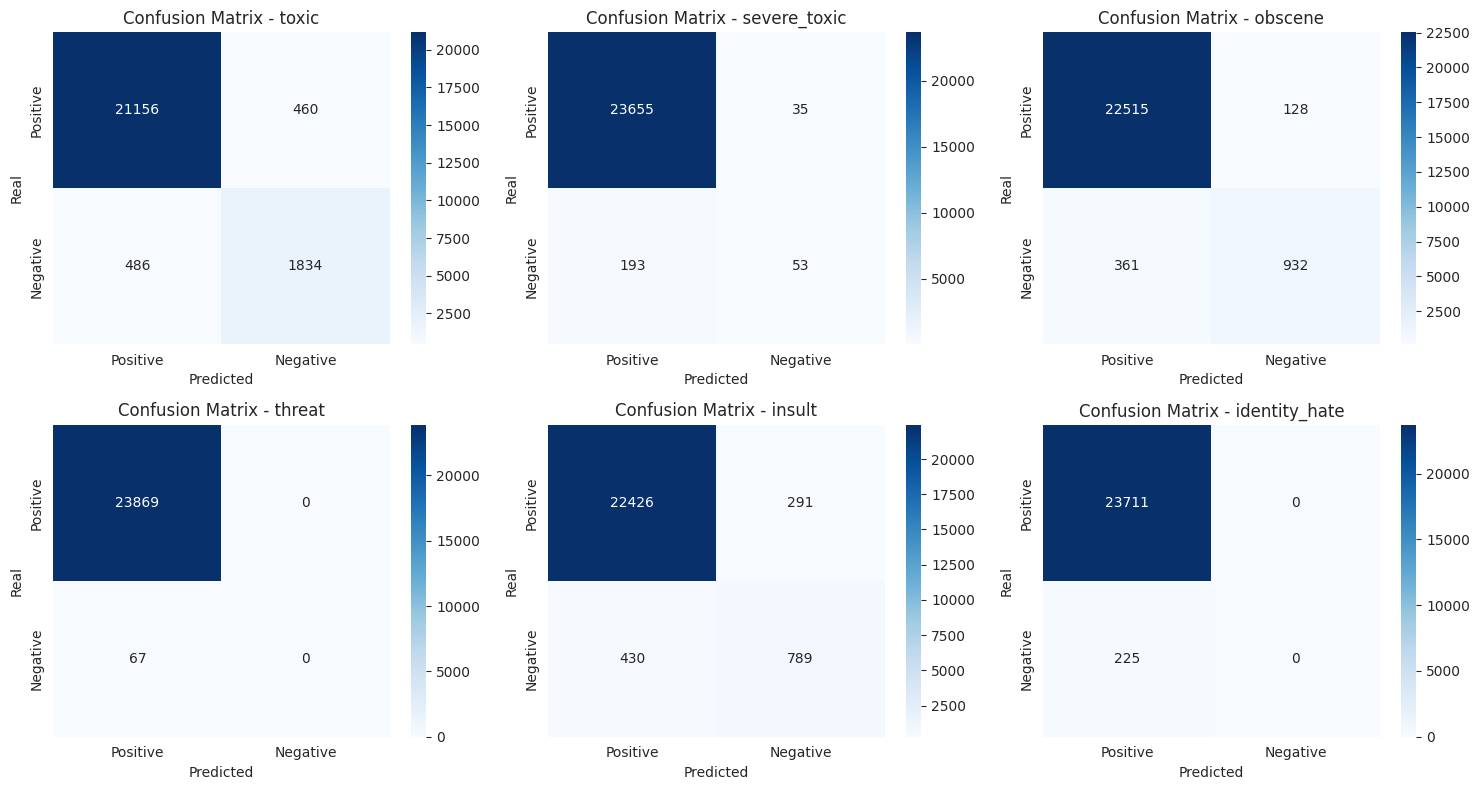

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, label in enumerate(labels):
    row, col = divmod(i, 3)  # Per posizionare il plot nella griglia 2x3

    # Creiamo la confusion matrix
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])

    # Creiamo il grafico con Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'], ax=axes[row, col])

    axes[row, col].set_title(f'Confusion Matrix - {label}')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Real')

plt.tight_layout()
plt.show()

Classes such as "Toxic" and "Obscene" have a good F1-score (~0.78-0.80), which means the model has a good chance of detecting them.
For the labels "Threat" the model has serious difficulties in identifying them. In the train set, the presence of these comments is 0.30%, i.e. a value of 0, which could therefore explain the result.

For the labels "Identity Hate" in the dataset, the distribution is 1% and suffers from the same reasons as for threat. In the absence of examples, the model cannot train effectively and then generalise to the test data.

It can be seen that classes with higher correlation are identified more correctly.
Those with low correlation, however, the model struggles to identify, probably due to the few examples in the dataset.

If the Hamming Loss is low, it means that the model is making few misclassifications on the labels.
If it is high, the model is making many wrong predictions.

# Balancing training ad fit Second Model

In [ ]:
X_train_np = X_train_sequences.numpy()
y_train_np = y_train_tensor.numpy()

In [ ]:
from sklearn.neighbors import NearestNeighbors

class MLSMOTE:
    def __init__(self, k_neighbors=5):
        self.k_neighbors = k_neighbors

    def fit_resample(self, X, y):
        # find nearest neighbours
        # nns contains the nearest neighbour indices for each point (excluding itself).
        nn = NearestNeighbors(n_neighbors=self.k_neighbors + 1)
        nn.fit(X)
        nns = nn.kneighbors(X, return_distance=False)[:, 1:]

        # Identifies minority classes
        # Finds indices of samples belonging to one or more classes (i.e. not belonging only to the 'non-toxic' majority class).
        minority_indices = np.where(y.sum(axis=1) > 0)[0]
        X_new, y_new = [], []

        #Create new synthetic samples
        for i in minority_indices:
            nn_idx = np.random.choice(nns[i]) # Randomly select a neighbour
            lambda_ = np.random.rand() # Generates a random number between 0 and 1
            X_synthetic = X[i] + lambda_ * (X[nn_idx] - X[i]) # New synthetic sample
            y_synthetic = np.logical_or(y[i], y[nn_idx]).astype(int) # Combine Labels
            X_new.append(X_synthetic)
            y_new.append(y_synthetic)

        # Concatenation of new data
        X_resampled = np.vstack((X, np.array(X_new)))
        y_resampled = np.vstack((y, np.array(y_new)))

        return X_resampled, y_resampled

# Applying MLSMOTE to training data
mlsmote = MLSMOTE(k_neighbors=5)
X_train_resampled, y_train_resampled = mlsmote.fit_resample(X_train_np, y_train_np)

# Check the new distribution
print(f'New classes distribution: \n{np.sum(y_train_resampled, axis=0)}')
print(f'Shape di X_train_resampled: {X_train_resampled.shape}')
print(f'Shape di y_train_resampled: {y_train_resampled.shape}')

New classes distribution: 
[21504.  2429. 12227.   737. 11399.  2066.]
Shape di X_train_resampled: (123057, 270)
Shape di y_train_resampled: (123057, 6)


In [ ]:
# Check original training distribution
print('Original distribution on training data:')
print(np.sum(y_train, axis=0))

# Check training distribution after MLSMOTE
print('\nDistribution after MLSMOTE:')
print(np.sum(y_train_resampled, axis=0))

Original distribution on training data:
toxic            10712
severe_toxic      1109
obscene           5893
threat             342
insult            5488
identity_hate      973
dtype: int64

Distribution after MLSMOTE:
[21504.  2429. 12227.   737. 11399.  2066.]


In [ ]:
print(f'Number of samples before: {X_train_sequences.shape[0]}')
print(f'Number of samples after: {X_train_resampled.shape[0]}')

Number of samples before: 111699
Number of samples after: 123057


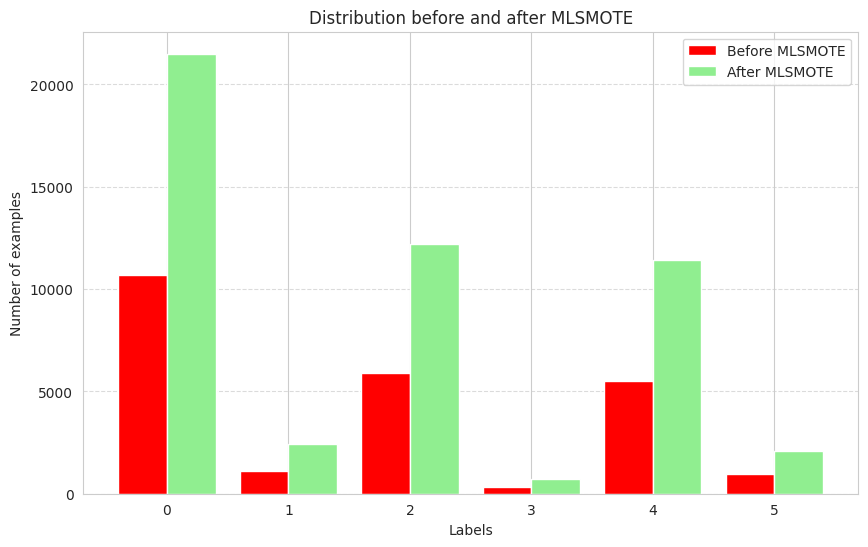

In [ ]:
# Count the number of samples for each class before and after balancing
class_distribution_before = np.sum(y_train, axis=0)
class_distribution_after = np.sum(y_train_resampled, axis=0)

#Class indices (x-axis)
class_labels = np.arange(len(class_distribution_before))

# Create bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.4

plt.bar(class_labels - bar_width/2, class_distribution_before, width=bar_width, label="Before MLSMOTE", color=['red'])

# Graph for distribution after MLSMOTE
plt.bar(class_labels + bar_width/2, class_distribution_after, width=bar_width, label="After MLSMOTE", color='lightgreen')

# labels and title
plt.xlabel("Labels")
plt.ylabel("Number of examples")
plt.title("Distribution before and after MLSMOTE")
plt.xticks(class_labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The algorithm attempts to generate new synthetic samples for minority classes by combining existing examples in the training data. This can help mitigate imbalance between classes, especially in multi-label contexts where an example may belong to more than one class.

We note that from the original distribution the examples generated for each positive label is doubled.

**Original distribution of classes:**
* 10712 toxic
* 1109  severe toxic
* 5893  obscene
* 342   threat
* 5488  insult
* 973   identity hate

**Distribution after MLSMOTE:**
* 21504 toxic
* 2429  severe toxic
* 12227 obscene
* 737   threat
* 11399 insult
* 2066  identity hate

We'll now try to re-train the model with the increased values to see if the change has an effect or if it is still too unbalanced.


In [ ]:
clear_session()
input = Input(shape=(max_length,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=64)(input)
x = Bidirectional(LSTM(units=128, return_sequences=True))(embedding_layer)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
x = Flatten()(x)
output = Dense(6, activation='sigmoid')(x)

# create model
model_resampled = Model(inputs=input, outputs=output)

# Compile model
model_resampled.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_resampled.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 270)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 270, 64)             │         640,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 270, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 270, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,002,822 (3.83 MB)

 Trainable params: 1,002,822 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

model_checkpoint = ModelCheckpoint(f'best model.keras', save_best_only=True, monitor='val_loss')

In [ ]:
history_resampled = model_resampled.fit(X_train_resampled,y_train_resampled,
                    batch_size = 64,
                    epochs = 5,
                    validation_data = (validation),
                    callbacks = [early_stopping,model_checkpoint]
                    )

Epoch 1/5
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 115s 58ms/step - accuracy: 0.9608 - loss: 0.1870 - val_accuracy: 0.9939 - val_loss: 0.0702
Epoch 2/5
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 141s 58ms/step - accuracy: 0.9895 - loss: 0.1259 - val_accuracy: 0.9939 - val_loss: 0.0668
Epoch 3/5
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 142s 58ms/step - accuracy: 0.9899 - loss: 0.1111 - val_accuracy: 0.9938 - val_loss: 0.0741
Epoch 4/5
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 150s 62ms/step - accuracy: 0.9898 - loss: 0.1013 - val_accuracy: 0.9939 - val_loss: 0.0638
Epoch 5/5
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 134s 58ms/step - accuracy: 0.9898 - loss: 0.0912 - val_accuracy: 0.9931 - val_loss: 0.0652


In [ ]:
y_pred_resampled = model.predict(testing)
y_pred_resampled = (y_pred > .5).astype(int)

748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step


In [ ]:
# Classification reports
print(classification_report(y_test, y_pred_resampled, target_names = ['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']))

               precision    recall  f1-score   support

        Toxic       0.80      0.79      0.79      2320
 Severe Toxic       0.60      0.22      0.32       246
      Obscene       0.88      0.72      0.79      1293
       Threat       0.00      0.00      0.00        67
       Insult       0.73      0.65      0.69      1219
Identity Hate       0.00      0.00      0.00       225

    micro avg       0.80      0.67      0.73      5370
    macro avg       0.50      0.40      0.43      5370
 weighted avg       0.75      0.67      0.70      5370
  samples avg       0.07      0.06      0.06      5370



In [ ]:
test_loss, test_accuracy = model_resampled.evaluate(testing)
print(f'Test Loss (resampled): {test_loss}, Test Accuracy (resampled): {test_accuracy}')

748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9935 - loss: 0.0623
Test Loss (resampled): 0.0643952488899231, Test Accuracy (resampled): 0.9941510558128357


In [ ]:
hamming_resampled = hamming_loss(y_test, y_pred_resampled)
print(f"Hamming Loss resampled: {hamming_resampled:.4f}")

Hamming Loss resampled: 0.0186


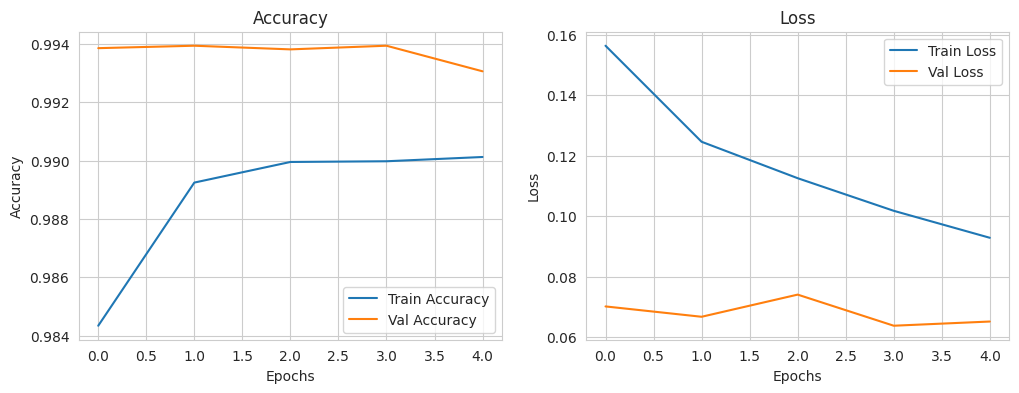

In [ ]:
# grafici loss e accuravy model resampled
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resampled.history['accuracy'], label='Train Accuracy')
plt.plot(history_resampled.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot Loss resampled
plt.subplot(1, 2, 2)
plt.plot(history_resampled.history['loss'], label='Train Loss')
plt.plot(history_resampled.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()

The accuracy on the training set (Train Accuracy) increases steadily with epochs, indicating that the model is learning from the data.
The accuracy on the validation set (Val Accuracy) remains very high and stable, with a slight fluctuation in the last epochs.
However, there is a slight decrease in Val Accuracy in the last epoch, which could indicate an onset of overfitting.

Train Loss gradually decreases, confirming that the model is reducing the error on the training data.
Val Loss, on the other hand, shows an irregular trend, with small fluctuations but no clear upward trend.
The absence of a net increase in Val Loss is a good sign, as it does not indicate obvious overfitting, but the fluctuations could suggest instability in the learning process.

Good overall performance: the model is learning well, with high accuracy and reduced loss.
Possible slight instability: fluctuations in Val Loss and the small drop in Val Accuracy suggest that the model could benefit from fine-tuning.

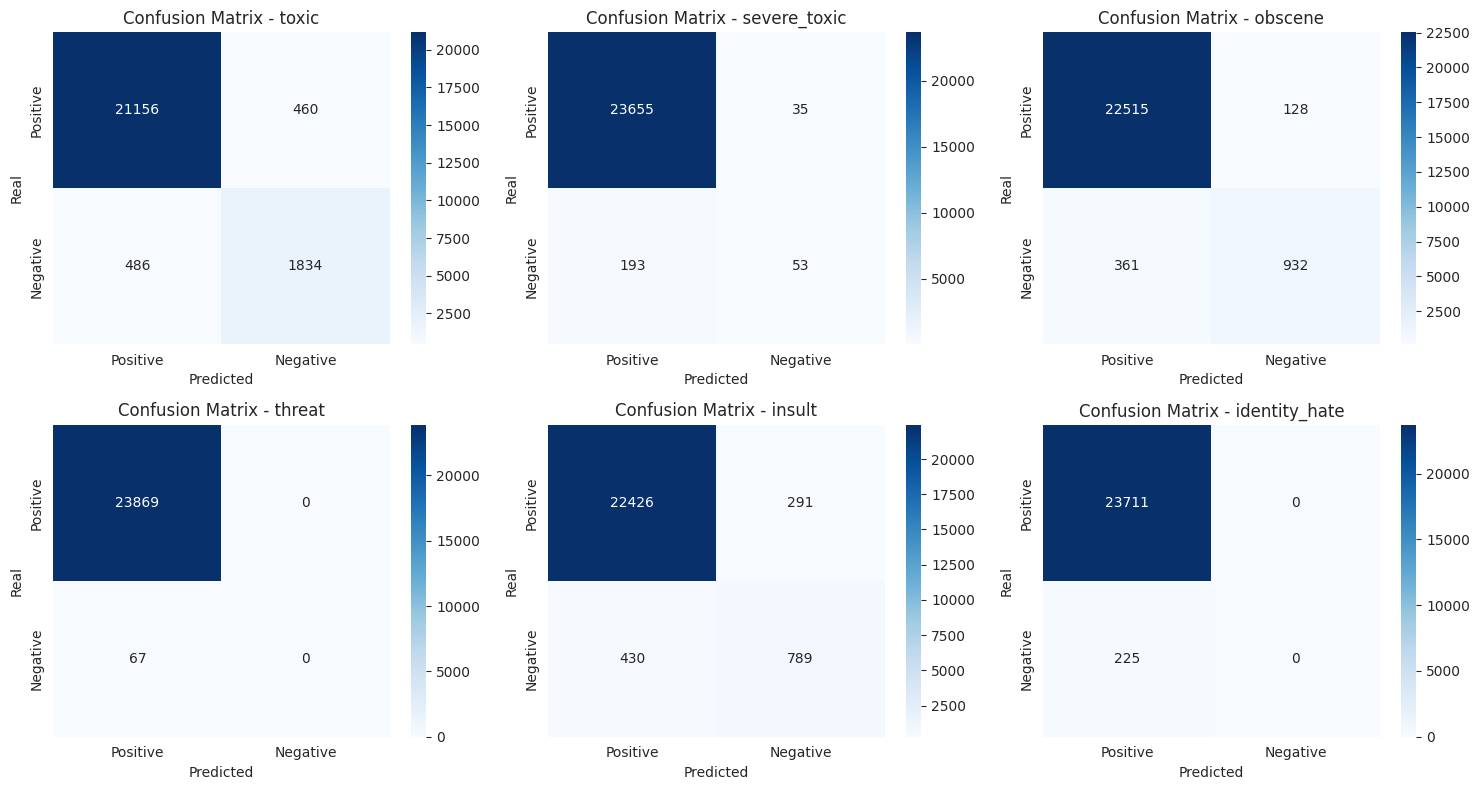

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i, label in enumerate(labels):
    row, col = divmod(i, 3)

    # Create confusion matrix
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_resampled[:, i])

    # Create plot
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"], ax=axes[row, col])

    axes[row, col].set_title(f"Confusion Matrix - {label}")
    axes[row, col].set_xlabel("Predicted")
    axes[row, col].set_ylabel("Real")

plt.tight_layout()
plt.show()

# Test pre-trained model with dataset

In [ ]:
import gensim.downloader as api

# Uploading pre-trained embeds (GloVe 100D)
glove_vectors = api.load("glove-wiki-gigaword-100")

# We create an embedding matrix with VOCAB_SIZE words
embedding_dim = 100
embedding_matrix = np.zeros((VOCAB_SIZE + 1, embedding_dim))

# Get the vocabulary as a list
vocabulary = vectorizer.get_vocabulary()

for i, word in enumerate(vocabulary):
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]

# We create the embedding layer with pre-trained weights
embedding_layer = Embedding(
    input_dim=VOCAB_SIZE + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # Uploading pre-trained embeds
    trainable=False  # We can also put True for light fine-tuning
)

# We build the model
input = Input(shape=(max_length,))
x = embedding_layer(input)
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Flatten()(x)
output = Dense(6, activation='sigmoid')(x)

model_glove = Model(inputs=input, outputs=output)

# compile and fit
model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_glove.fit(training,
          epochs=5,
          batch_size=64,
          validation_data=(validation))

# prediction on test
y_pred_glove = model_glove.predict(testing)
y_pred_glove = (y_pred_glove > 0.5).astype(int)

print(classification_report(y_test, y_pred_glove, target_names=['Toxic', 'Severe Toxic', 'Obscene', 'Threat', 'Insult', 'Identity Hate']))

[==================================================] 100.0% 128.1/128.1MB downloaded
Epoch 1/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 159s 44ms/step - accuracy: 0.9042 - loss: 0.0826 - val_accuracy: 0.9659 - val_loss: 0.0539
Epoch 2/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 153s 44ms/step - accuracy: 0.9249 - loss: 0.0553 - val_accuracy: 0.9477 - val_loss: 0.0502
Epoch 3/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 204s 44ms/step - accuracy: 0.9494 - loss: 0.0492 - val_accuracy: 0.9624 - val_loss: 0.0501
Epoch 4/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 154s 44ms/step - accuracy: 0.9368 - loss: 0.0448 - val_accuracy: 0.9619 - val_loss: 0.0522
Epoch 5/5
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 155s 44ms/step - accuracy: 0.9097 - loss: 0.0398 - val_accuracy: 0.9081 - val_loss: 0.0552
748/748 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step
               precision    recall  f1-score   support

        Toxic       0.79      0.77      0.78      2320
 Severe Toxic       0.49      0.28      0.35       246
      Obscene       0.87      0.72      0.79  

In [ ]:
hamming_glove = hamming_loss(y_test, y_pred_glove)
print(f"Hamming Loss: {hamming_glove:.4f}")

Hamming Loss: 0.0191


Overall improvement over the original model, especially for the labels Identity Hate and Threat, which were almost ignored before.

Recall remains a problem for less represented classes, such as Severe Toxic, Threat and Identity Hate.

Reduced overfitting, but we could still try to improve the model's ability to generalise.

**Possible improvements:**
Balancing the dataset: MLSMOTE might help, but the main problem seems to be an unbalanced dataset with few instances of some classes. We could try to rebalance the data better.

Adding more training data with textual augmentation, e.g. synonyms and paraphrases.

Experiment with more advanced models, such as DistilBERT or RoBERTa, which could improve especially on classes with few instances.



# Inference

In [ ]:
text = "I hate you, you are the worst person ever!"

text_sequence = vectorizer(np.array([text]))

pred = model.predict(text_sequence)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i, label in enumerate(labels):
    print(f"{label}: {pred[0][i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
toxic: 0.8593
severe_toxic: 0.0258
obscene: 0.2207
threat: 0.0440
insult: 0.4157
identity_hate: 0.1145


In [ ]:
text_2 = "I love you, you are my world!"
text_sequence = vectorizer(np.array([text_2]))
pred_2 = model.predict(text_sequence)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i, label in enumerate(labels):
    print(f"{label}: {pred_2[0][i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
toxic: 0.3692
severe_toxic: 0.0028
obscene: 0.0549
threat: 0.0146
insult: 0.1006
identity_hate: 0.0249


In [ ]:
text_3 = "You can't do anything right, you're just a waste of time"
text_sequence = vectorizer(np.array([text_3]))
pred_3 = model.predict(text_sequence)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i, label in enumerate(labels):
    print(f"{label}: {pred_3[0][i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
toxic: 0.6490
severe_toxic: 0.0068
obscene: 0.1125
threat: 0.0267
insult: 0.2299
identity_hate: 0.0511


In [ ]:
text_4 = "Well done, if you combine your passion for Ai and data science, you could develop highly sought-after skills"
text_sequence = vectorizer(np.array([text_4]))
pred_4 = model.predict(text_sequence)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i, label in enumerate(labels):
    print(f"{label}: {pred_4[0][i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
toxic: 0.0034
severe_toxic: 0.0000
obscene: 0.0002
threat: 0.0001
insult: 0.0003
identity_hate: 0.0001


In [ ]:
text_5 = 'Nobody wants to listen to your ridiculous opinions, you are just here to cause trouble'
text_sequence = vectorizer(np.array([text_5]))
pred_5 = model.predict(text_sequence)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for i, label in enumerate(labels):
    print(f"{label}: {pred_5[0][i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
toxic: 0.6636
severe_toxic: 0.0116
obscene: 0.1131
threat: 0.0393
insult: 0.2468
identity_hate: 0.0664


# Conclusion

The dataset appears to be a limiting factor in the model's performance.

The best-identified labels are those that are most correlated and well-represented, suggesting that data distribution plays a crucial role.

To improve the model, it may be necessary to balance the dataset or implement techniques that enhance the identification of underrepresented categories.